In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
import scipy
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## test 1: pick a day, gather all years

In [2]:
all_hours_paths, time_dim = [], []

day = 250
for i in range(2002,2024):
    mswep_dir = f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{i}/'
    this_day_paths = sorted(glob(mswep_dir+f'{i}{day}.*.nc'))
    all_hours_paths.append(this_day_paths)

In [3]:
#flatten nested lists
mswep_paths = [
    x
    for xs in all_hours_paths
    for x in xs
]

In [4]:
da = xr.open_mfdataset(mswep_paths[::-1],
                       concat_dim='time',
                              combine="nested")

In [6]:
start = datetime.datetime.now()
h = da.precipitation.data.compute()
finish = datetime.datetime.now()
print(f'finished in {(finish-start).total_seconds()}s')

finished in 11.076328s


In [7]:
from nimbl import get_metadata
conus_grid = get_metadata.get_metadata('grib2_grid', model='blend', region='co')
conus_grid_def = grib2io.Grib2GridDef(*conus_grid)

In [8]:
#plot 24 hr precip for one location

stp = grib2io.interpolate_to_stations(h,
    'bilinear',
    conus_grid_def,
    [44.94830673733262],
    [-93.14513224521535])

([<matplotlib.axis.XTick at 0x15434e112170>,
 [Text(0, 0, '0'),
  Text(3, 0, '3'),
  Text(6, 0, '6'),
  Text(9, 0, '9'),
  Text(12, 0, '12'),
  Text(15, 0, '15'),
  Text(18, 0, '18'),
  Text(21, 0, '21')])

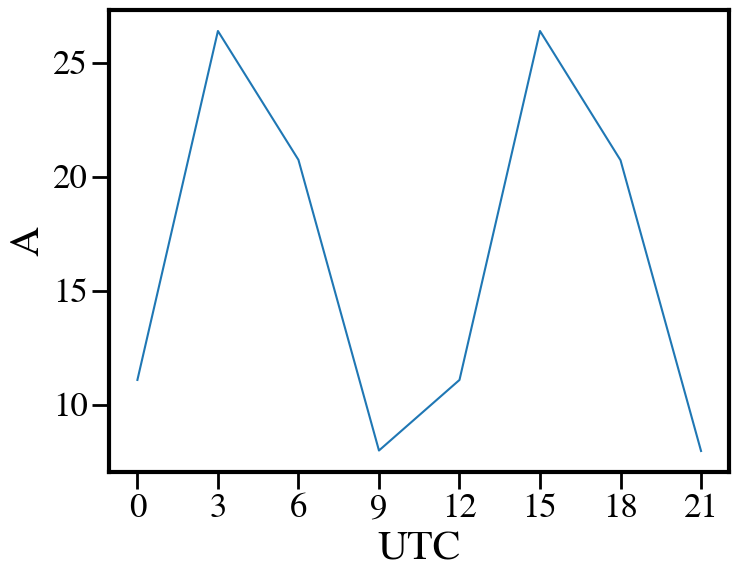

In [9]:
hours = [0,3, 6, 9, 12, 15, 18, 21]
total=[]
for i in range(len(hours)):
    this_hr = np.ravel(stp)[i::4]
    total.append(np.sum(this_hr))
plt.plot(hours, total)

plt.ylabel('A')
plt.xlabel('UTC')
plt.xticks(hours)

## Dealing with time

MSWEP's native time unit is UTC...to make a diurnal cycle that actually reflects the daytime hours at each grid point, need to convert from UTC --> local time (probably via timezones instead of actual local solar time*). But since, e.g., 3z UTC is 10 pm eastern **the previous day** we need to be aware of when the days transition, because we'll need to pick up the previous day's data too. 

*There's also a discussion to be had about which time to convert to. Each grid point will have a unique local time (non-linearly dependent on lat/lon). Is it best to be as general as possible -- like converting to just the time defined by the time zone, which is just a function of longitude?

For now, let's use local solar time (dependent on longitude). In order to determine *which* files need to be loaded, load a dummy file with the lats and lons; from there, determine the time and correct files for each grid point. This is a grid point by grid point process which feels clunky? Which leads to another question: when it comes time to put this into the supplemental locations algorithm, do we want to determine the diurnal cycle params dynamically? Or for each day, figure out timing, params then save each day to a file

In [5]:
init = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2023/2023001.03.nc')

In [ ]:
def to_solar_time(date_time, longitude):
    utc_dt = date_time
    return utc_dt + datetime.timedelta(hours=longitude / np.pi * 12)

In [ ]:
local_time = time[0].astype('M8[ms]').astype('O') + datetime.timedelta(hours=np.deg2rad(longs[1000,1000]) / np.pi * 12)